In [1]:
using Distributed
addprocs(5)
@everywhere using DrWatson
@everywhere @quickactivate "Qwind"
using Qwind
include("../../scripts/plotting.jl")

      From worker 6:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 4:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 2:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 5:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 3:	  Activating environment at `~/code/Qwind.jl/Project.toml`


Main.QwindPlotting

In [2]:
model = Model("./config.yaml");
try
    rm(model.config[:integrator][:save_path], recursive=true)
catch
end
iterations_dict = Dict();
run!(model, iterations_dict);

┌ Info: Saving results to ./data
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:104
┌ Info: Iterating streamlines...
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:76
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
┌ Info: Integration of iteration 1 ended!
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:81
┌ Info: Saving results...
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:82
┌ Info: Done
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:85
┌ Info: Wind properties
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:87
┌ Info: Mass loss fraction 0.0
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:88
┌ Info: Updating radiative transfer... 
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/regular_grid.jl:37
┌ Info: Constructing wind hull...
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/density_interpolators/interpolation.jl:34
┌ Info: Trying wind hull with 6 sig digits...
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/den

In [425]:
using PyPlot, ColorSchemes, Colors
include("../../scripts/plotting.jl")
include("./style.jl")
mnras_width = 252/72.27
dpi=350
cmap = colorschemes[:dense]
cmap_pl = ColorMap("cmap", cmap.colors)

# Wind Hull

In [5]:
hull1 = iterations_dict[2]["radiative_transfer"].density_interpolator.hull
hull2 = iterations_dict[3]["radiative_transfer"].density_interpolator.hull
integ1 = iterations_dict[1]["integrators"]
integ2 = iterations_dict[2]["integrators"];

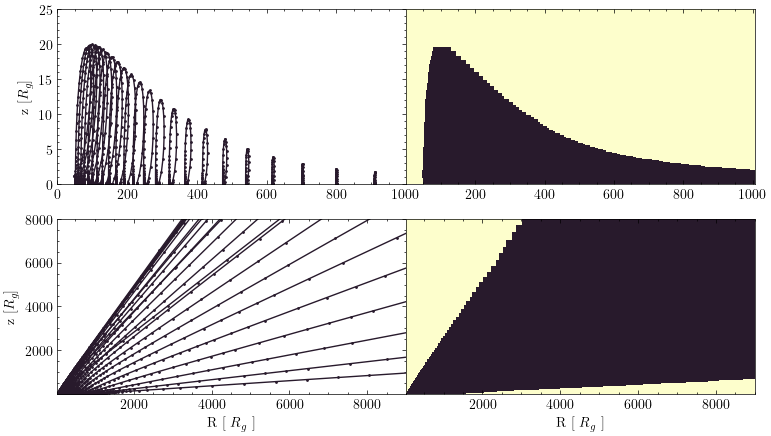

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(9,5))

QwindPlotting.plot_streamlines(integ1[1:2:end], fig=fig, ax=ax[1,1], color = "#" * hex(convert(RGB, get(cmap, 1))))
QwindPlotting.plot_wind_hull(hull1, fig=fig, ax=ax[1,2], zmax=25, nr=500, nz=500, cmap=cmap_pl)

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, ax=ax[2,1], color = "#" * hex(convert(RGB, get(cmap, 1))))
QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,2], rmax=10000, zmax=10000, nr=500, nz=500, cmap=cmap_pl)

ax[1,1].set_xlim(0,1000)
ax[1,1].set_ylim(0,25)
ax[1,1].set_xlabel("")

ax[2,1].set_xlim(40, 9000)
ax[2,1].set_ylim(1e-6, 8000)
ax[2,2].set_xlim(40, 9000)
ax[2,2].set_ylim(1e-6, 8000)

ax[2,2].yaxis.set_ticks([])
ax[1,2].yaxis.set_ticks([])

ax[2,2].set_xlabel(L"R [ $R_g$ ]")
ax[2,1].set_xlabel(L"R [ $R_g$ ]")

plt.subplots_adjust(wspace=0)
fig.savefig("plots/wind_hull.pdf")

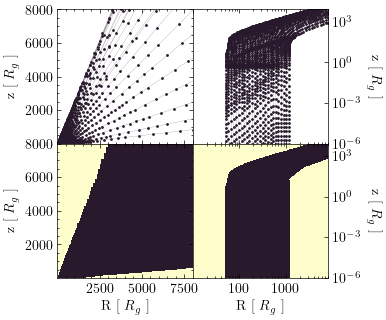

In [159]:
fig, ax = plt.subplots(2, 2, figsize=(mnras_width, mnras_width))#, figsize=(4,6))

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, linewidth=0.1, ax=ax[1,1], color = "#" * hex(convert(RGB, get(cmap, 1))))
QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,1], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl)

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, ax=ax[1,2], linewidth=0.1, color = "#" * hex(convert(RGB, get(cmap, 1))))
QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,2], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl)

ax[1,1].set_xlim(10,8000)
ax[1,1].set_ylim(1e-6, 8000)
#ax[1,1].set_xscale("log")
#ax[1,1].set_yscale("log")

ax[1,2].set_xlim(10,8000)
ax[1,2].set_ylim(1e-6, 8000)
ax[1,2].set_xscale("log")
ax[1,2].set_yscale("log")
ax[1,2].yaxis.tick_right()


ax[2,1].set_xlim(10,8000)
ax[2,1].set_ylim(1e-6, 8000)
#ax[2,1].set_xscale("log")
#ax[2,1].set_yscale("log")

ax[2,2].set_xlim(10,8000)
ax[2,2].set_ylim(1e-6, 8000)
ax[2,2].set_xscale("log")
ax[2,2].set_yscale("log")
ax[2,2].yaxis.tick_right()



ax[2,1].set_xlabel(L"R [ $R_g$ ]")
ax[2,2].set_xlabel(L"R [ $R_g$ ]")
ax[1,1].set_ylabel(L"z [ $R_g$ ]")
ax[2,1].set_ylabel(L"z [ $R_g$ ]")

ax[1,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[1,2].yaxis.set_label_position("right")
ax[2,2].yaxis.set_label_position("right")

ax[2,1].set_xticks([2500, 5000, 7500])
ax[2,1].set_xticklabels([2500, 5000, 7500])

ax[2,2].set_xticks([1e2, 1000])
ax[2,2].set_xticklabels([100, 1000])

plt.subplots_adjust(wspace=0, hspace=0)
#fig.savefig("plots/wind_hull.pdf")

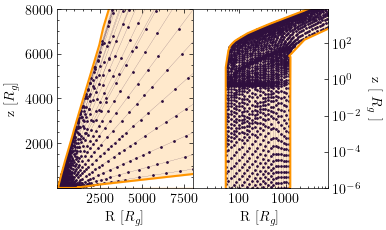

In [437]:
fig, ax = plt.subplots(1, 2, figsize=(mnras_width, mnras_width / 1.5))#, figsize=(4,6))

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, linewidth=0.1, ax=ax[1], color = "#" * hex(convert(RGB, get(cmap, 1))))
#QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,1], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl)

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, ax=ax[2], linewidth=0.1, color = "#" * hex(convert(RGB, get(cmap, 1))))
#QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,2], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl)

ax[1].set_xlim(10,8000)
ax[1].set_ylim(1e-6, 8000)

ax[2].set_xlim(10,8000)
ax[2].set_ylim(1e-6, 8000)
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].yaxis.tick_right()


#ax[1,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2].yaxis.set_label_position("right")

ax[1].set_xticks([2500, 5000, 7500])
ax[1].set_xticklabels([2500, 5000, 7500])

ax[2].set_xticks([1e2, 1000])
ax[2].set_xticklabels([100, 1000])

hull_ps = 10 .^ reduce(hcat, hull2.vertices)
ax[1].plot(hull_ps[1,:], hull_ps[2,:], linewidth=1.5, color = "C2")
ax[1].fill_between(hull_ps[1,:], hull_ps[2,:], alpha=0.2, color = "C2")

ax[2].plot(hull_ps[1,:], hull_ps[2,:], linewidth=1.5, color = "C2")
ax[2].fill_between(hull_ps[1,:], hull_ps[2,:], alpha=0.2, color = "C2")

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig("plots/wind_hull.pdf", dpi=dpi)

# Density Interpolation Grid

In [314]:
integrators = iterations_dict[2]["integrators"];
r, z, n = Qwind.reduce_integrators(integrators, n_timesteps = 1000)
r0s = [integrator.p.r0 for integrator in integrators]
grid = Qwind.construct_interpolation_grid(r, z, n, r0s, hull2, nr = 500, nz = 500);

In [431]:
cmap = colorschemes[:matter]
cmap_pl = ColorMap("cmap", cmap.colors)

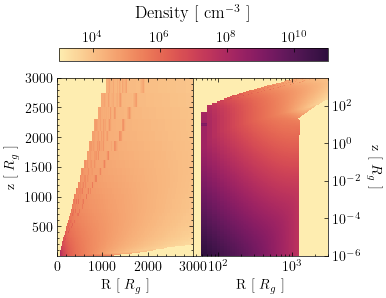

In [432]:
fig, ax = plt.subplots(1, 2, figsize=(mnras_width, 0.7 * mnras_width))

rmax = 3e3
zmax = 3e3

_, _, cm = QwindPlotting.plot_density_grid(grid, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e3, vmax=1e11, zmax=zmax, rmax=rmax, nr=250, nz=250, colorbar=false)
QwindPlotting.plot_density_grid(grid, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e3, vmax=1e11, zmax=zmax, rmax=rmax, nr=250, nz=250, colorbar=false)

ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xlim(0, rmax)

ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlim(45, rmax)
ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title(L"Density [ cm$^{-3}$ ]", pad=10)

plt.subplots_adjust(wspace=0)

fig.savefig("plots/density_grid.pdf", dpi = dpi)

# Ray tracing

In [533]:
function get_points_tracing(iterator, ri, zi, rf, zf)
    set_iterator!(grid.iterator, ri, zi, rf, zf)
    points = [[ri ,zi]]
    while !grid.iterator.finished
        push!(points, copy(grid.iterator.intersection))
        next_intersection!(grid.iterator)
    end
    push!(points, copy(grid.iterator.intersection))
    points = reduce(hcat, points)
    points
end

get_points_tracing (generic function with 1 method)

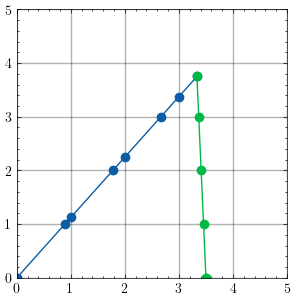

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fedacc99e20>

In [538]:
fig, ax = plt.subplots(figsize=(mnras_width, mnras_width))
r_range = range(0, 5, length=6)
z_range = range(0, 5, length=6)
dgrid = ones(length(r_range), length(z_range))
grid = InterpolationGrid(r_range, z_range, dgrid)
for r in grid.r_range
    ax.axvline(r, color = "black", alpha=0.3)
end
for z in grid.z_range
    ax.axhline(z, color = "black", alpha=0.3)
end
ax.set_xlim(0,5)
ax.set_ylim(0,5)
points = get_points_tracing(grid.iterator, 0.0, 0.0, 4/1.2, 4.5/1.2)
points2 = get_points_tracing(grid.iterator, 3.5, 0.0, 4/1.2, 4.5/1.2)

ax.plot(points[1,:], points[2,:], "o-")
ax.plot(points2[1,:], points2[2,:], "o-")

In [485]:
grid.iterator.intersection
next_intersection!(grid.iterator)
grid.iterator.intersection


2-element Vector{Float64}:
 287.5
  38.33333333333333

# X-Ray Grid

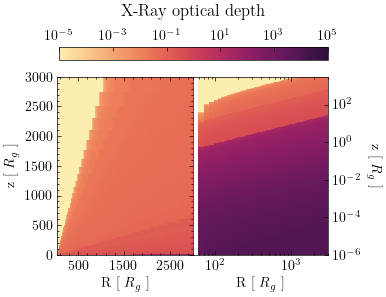

In [433]:
Rg = model.bh.Rg
xl = model.rad.xray_luminosity
MultipleLocator = matplotlib.ticker.MultipleLocator
ScalarFormatter = matplotlib.ticker.ScalarFormatter 


fig, ax = plt.subplots(1, 2, figsize=(mnras_width, 0.7 * mnras_width))

rmax = 3e3
zmax = 3e3

_, _, cm = QwindPlotting.plot_xray_grid(grid, xl, Rg, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e-5, vmax=1e5, nr=250, nz=250, rmax=rmax, zmax=zmax, colorbar=false)
QwindPlotting.plot_xray_grid(grid, xl, Rg, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e-5, vmax=1e5, nr=250, nz=250, rmax=rmax, zmax=zmax, colorbar=false)

ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
#ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].set_xlim(50, rmax)
ax[2].set_ylim(1e-6, zmax)
#ax[2].yaxis.set_tick_params(labelright="on", labelleft="off")
#ax[2].yaxis.set_minor_locator(MultipleLocator(1000))
ax[2].yaxis.tick_right()
#ax[2].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].set_ylim(0, zmax)
ax[1].set_xlim(50, rmax)
ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xticks([500, 1500, 2500])

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title("X-Ray optical depth", pad=10)

plt.subplots_adjust(wspace=0)
fig.savefig("plots/xray_tau_grid.pdf", dpi=dpi)

# UV Grid

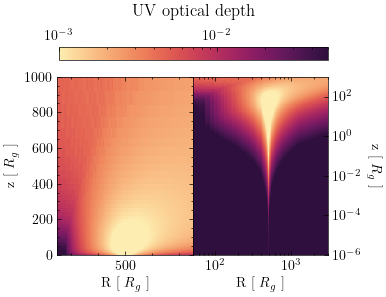

In [434]:
Rg = model.bh.Rg

fig, ax = plt.subplots(1, 2, figsize=(mnras_width, 0.7 * mnras_width))

rmin=1
rmax = 1e3
zmax = 1e3

_, _, cm = QwindPlotting.plot_uv_grid(grid, 500.0, Rg, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e-3, vmax=5e-2, nr=250, nz=250, rmin=rmin, rmax=rmax, zmax=zmax, colorbar=false)
QwindPlotting.plot_uv_grid(grid, 500.0, Rg, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e-3, vmax=5e-2, nr=250, nz=250, rmin=rmin, rmax=3*rmax, zmax=zmax, colorbar=false)

ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
#ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].set_xlim(50, 3*rmax)
ax[2].set_ylim(1e-6, zmax)
#ax[2].yaxis.set_tick_params(labelright="on", labelleft="off")
#ax[2].yaxis.set_minor_locator(MultipleLocator(1000))
ax[2].yaxis.tick_right()
#ax[2].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].set_ylim(0, zmax)
ax[1].set_xlim(rmin, rmax)
ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xticks([500, 1500, 2500])
ax[1].set_xlim(0, rmax)
ax[1].set_ylim(0, zmax)

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title("UV optical depth", pad=10)

plt.subplots_adjust(wspace=0)
fig.savefig("plots/uv_tau_grid.pdf", dpi=dpi)